**Please don't edit this cell!**

# Marks and Feedback

**Total Marks:**   XX/100

**Overall comments:**


## Part 1. Investigations into Neural Networks (35 marks)

* **Task 1**:   *Experiments with learning rate schedules* - XX/5
    * learning rate schedulers implemented
    * experiments carried out
    * further comments


* **Task 2**:   *Experiments with regularisation* - XX/5
    * L1 experiments
    * L2 experiments
    * dropout experiments
    * annealed dropout implmented
    * further experiments carried out
    * further comments
    

* **Task 3**:   *Experiments with pretraining* - XX/15
    * autoencoder pretraining implemented
    * denoising autoencoder pretraining implemented
    * CE layer-by-layer pretraining implemented
    * experiments
    * further comments


* **Task 4**:   *Experiments with data augmentation* - XX/5
    * training data augmneted using noise, rotation, ...
    * any further augmnetations
    * experiments 
    * further comments


* **Task 5**:   *State of the art* - XX/5
    * motivation for systems constructed
    * experiments
    * accuracy of best system
    * further comments



## Part 2. Convolutional Neural Networks (55 marks)

* **Task 6**:   *Implement convolutional layer* - XX/20
    * linear conv layer
    * sigmoid conv layer
    * relu conv layer
    * any checks for correctness
    * loop-based or vectorised implementations
    * timing comparisons


* **Task 7**:   *Implement maxpooling layer* - XX/10
    * implementation of non-overlapping pooling
    * generic implementation
    * any checks for correctness


* **Task 8**:   *Experiments with convolutional networks* - XX/25
    * 1 conv layer (1 fmap)
    * 1 conv layer (5 fmaps)
    * 2 conv layers
    * further experiments



## Presentation (10 marks)

* ** Marks:**   XX/10
    * Concise description of each system constructed
    * Experiment design and motivations for different systems
    * Presentation of results - graphs, tables, diagrams
    * Conclusions



# Coursework #2

## Introduction


## Previous Tutorials

Before starting this coursework make sure that you have completed the following labs:

* [04_Regularisation.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/04_Regularisation.ipynb) - regularising the model
* [05_Transfer_functions.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/05_Transfer_functions.ipynb) - building and training different activation functions
* [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb) - Notes on numpy and tensors


## Submission
**Submission Deadline:  Thursday 14 January 2016, 16:00** 

Submit the coursework as an ipython notebook file, using the `submit` command in the terminal on a DICE machine. If your file is `06_MLP_Coursework1.ipynb` then you would enter:

`submit mlp 2 06_MLP_Coursework1.ipynb` 

where `mlp 2` indicates this is the second coursework of MLP.

After submitting, you should receive an email of acknowledgment from the system confirming that your submission has been received successfully. Keep the email as evidence of your coursework submission.

**Please make sure you submit a single `ipynb` file (and nothing else)!**

**Submission Deadline:  Thursday 14 January 2016, 16:00** 



## Getting Started
Please enter your student number and the date in the next code cell.

In [ ]:
#MLP Coursework 2
#Student number: s1567688
#Date: 10/12/2015

# Part 1. Investigations into Neural Networks (35 marks)

In this part you are may choose exactly what you implement. However, you are expected to express your motivations, observations, and findings in a clear and cohesive way. Try to make it clear why you decided to do certain things. Use graphs and/or tables of results to show trends and other characteristics you think are important. 

For example, in Task 1 you could experiment with different schedulers in order to compare their convergence properties. In Task 2 you could look into (and visualise) what happens to weights when applying L1 and/or L2 regularisation when training. For instance, you could create sorted histograms of weight magnitudes in in each layer, etc..

**Before submission, please collapse all the log entries into smaller boxes (by clicking on the bar on the left hand side)**

### Task 1 - Experiments with learning rate schedules (5 marks)

Investigate the effect of learning rate schedules on training and accuracy.  Implement at least one additional learning rate scheduler mentioned in the lectures. 

#### Below is the exponential learning rate scheduler implemented:

In [ ]:
# %load -s LearningRateExponential mlp/schedulers.py
class LearningRateExponential(LearningRateScheduler):
    '''
        Exponentially decreasing learning rate.
        zero_rate - rate to multiply the epoch/training size by, keyword argument
    '''
    def __init__(self, start_rate, max_epochs, training_size, zero_rate=0.5):
        
        #Set the training size
        self.training_size = training_size
        
        #Do checks as both need to be greater than zero
        assert start_rate > 0, (
            "starting rate expected to be > 0, got %f" % start_rate
        )
        assert zero_rate > 0, (
            "zero rate expected to be > 0, got %f" % zero_rate
        )
        
        #Init the super class with the max epochs
        super(LearningRateExponential, self).__init__(max_epochs)
        
        #Set the class properties
        self.start_rate = start_rate
        self.zero_rate = zero_rate
        self.rate = start_rate
        self.epoch = 1
    
    #Reset the epochs and start_rate
    def reset(self):
        self.rate = self.start_rate
        self.epoch = 0
        
    #Return the current rate
    def get_rate(self):
        return self.rate  
    
    def get_next_rate(self,current_accuracy=None):  
        # If epochs have over ran return zero
        if ( (self.max_epochs > 10000) or (self.epoch >= self.max_epochs) ):
            self.rate = 0.0
        else:
            #Use float or it won't return properly.
            self.rate = self.zero_rate * numpy.exp(-float(self.epoch)/float(self.training_size))
            #Increase the epochs for the next round
            self.epoch += 1
        #Log the rate for checking in logger - Not entirely needed
        logger.info(self.rate)
        return self.rate


Firstly I decided to investigate some base rates as follows:

       | Rate       | Hyper Parameters                                           |
       | Fixed      | Learning Rate : 0.5                                        |
       | List       | Start Rate : 0.5, decrease by 0.01 per epoch               |
       | NewBob     | Learning Rate : 0.5  min_error/scale = 0.05, patience = 10 |
       | Exponential| Start Rate : 0.5, Training Size = 100                      |
       
The training size was set to 100, as each batch_size = 100.
This resulted in the below results:

In [ ]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['Exponential', 'Fixed', 'NewBob','List']

for i in xrange(0,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[45:len(shelve_p[lists+str(i)][0])], train_error[45:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(0,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[45:len(shelve_p[lists+str(i)][0])], train_error[45:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
    
    %PUT SIDE BY SIDE and include table of end testing

For different number of layers, with each layer altering the number of neurons in the network equally, for example when I added 3 layers there were 400 neurons in each layer.
In layer 1 there were 800 neurons, in the second layer there were 600 neurons and in the third layer there were 400 neurons.

As can be seen, by the following results the fixed learning rate performed best, followed by exponential, the list and newBob stopped before the number of max epochs due to the patience factor being too low, however it performed the worst.

This is backed up by the testing results:

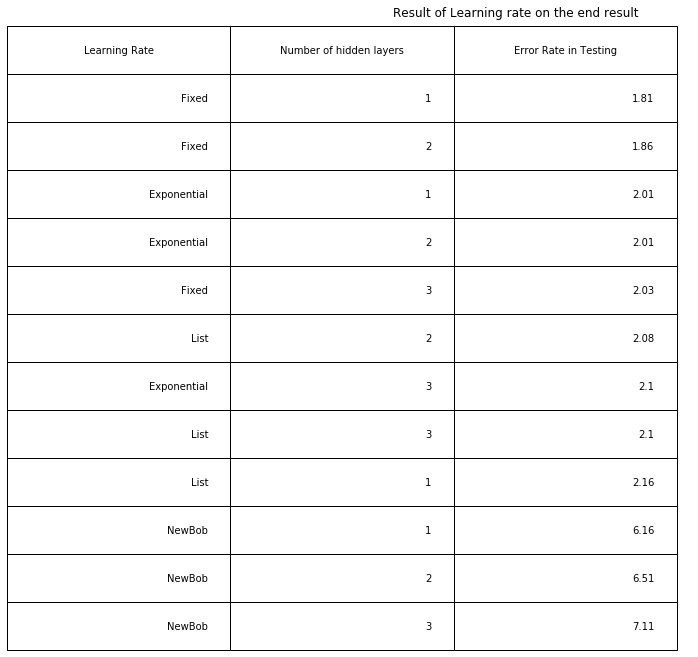

In [1]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
tracker = []

train_cont = ['Exponential', 'Fixed', 'NewBob','List']
for item in train_cont:
    for val in xrange(0,3):
        tracker.append([item,str(val+1), 100-(100*shelve_p[(item+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[2])
#Plot table, with these columns
columns = ('Learning Rate', 'Number of hidden layers', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of Learning rate on the end result')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

As can be seen the fixed learning rate continually performs better than other rates with the same number of hidden layers.
I believed it to be strange as it had the least hyper-parameters, hence it was easier to experiment with, this lead me to believe that I needed to experiment with the hyper parameters of newBob and exponential more.
I didn't experiment with the list, as the list could be fine tuned on a epoch by epoch basis, and is obvious how the decreases affect the overall performance.

For the newBob experiments I used only the network with 2 & 3 hidden layers, as I believe this is were newBob can perform best.
Firstly I experimented with the newBob patience hyper-parameter of 10, 25 and 100, keeping all other hyper-parameters the same.

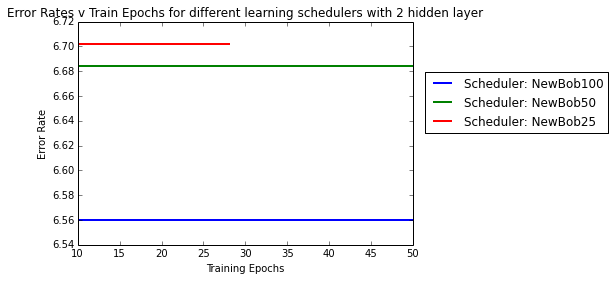

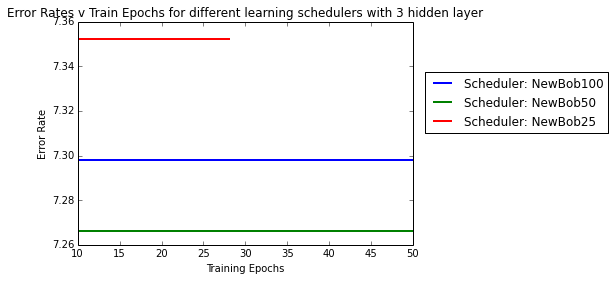

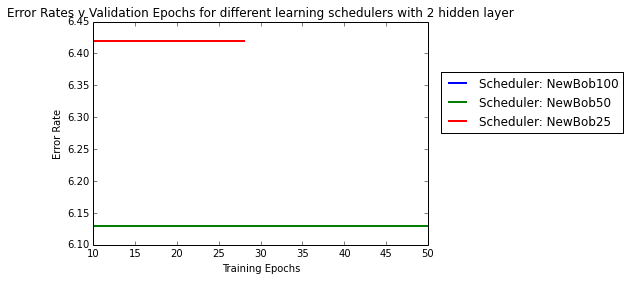

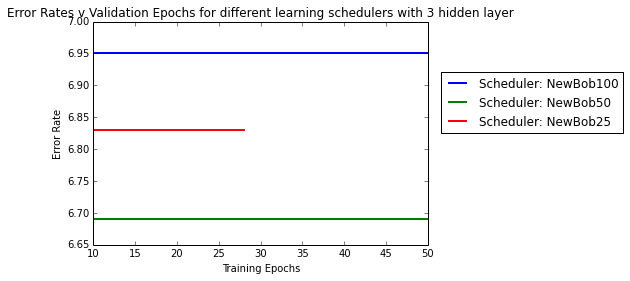

In [2]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100', 'NewBob50', 'NewBob25']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

As can be seen the patience of 50 did ~.1% better than any other patience. 
I next changed the hyper-parameter scale_by to 0.5, keeping the network and patience hyper-parameters from the previous experiment.

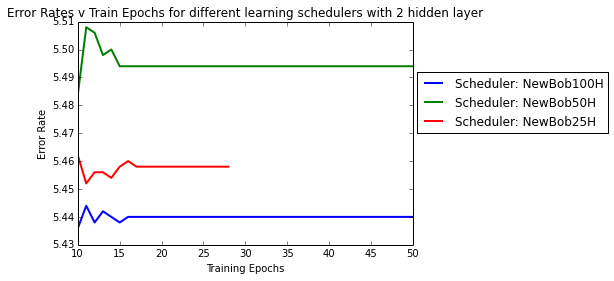

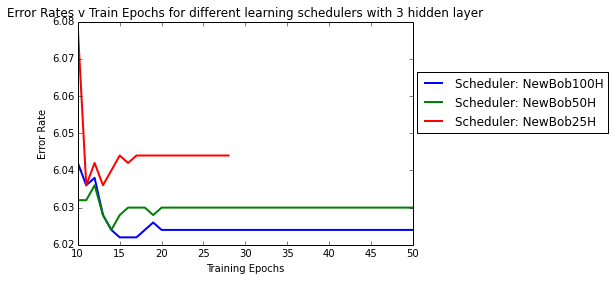

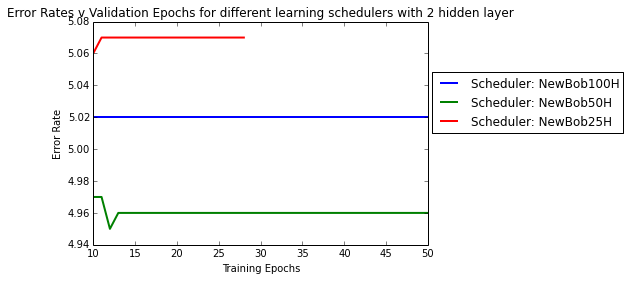

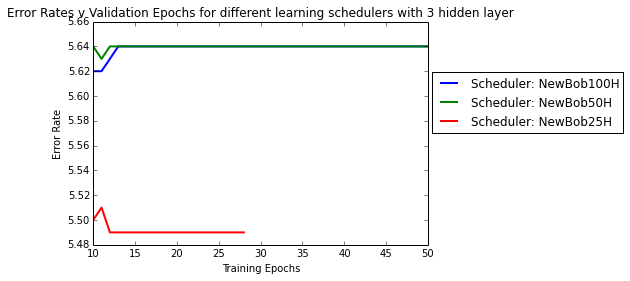

In [3]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100H', 'NewBob50H', 'NewBob25H']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

As can be seen, the change in scaling factor drastically changes which patience factor does better, with a patience of 100 seemingly doing better in training, owever in evaluation it alters between the patience settings of 25 and 50.

These suggest that all hyper-parameters matter and need some finetuning in relation to each other, to prove this I altered the final newBob specific hyper-parameter, altering the min_error to 0.5.

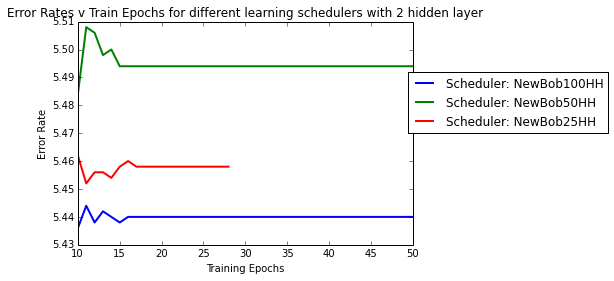

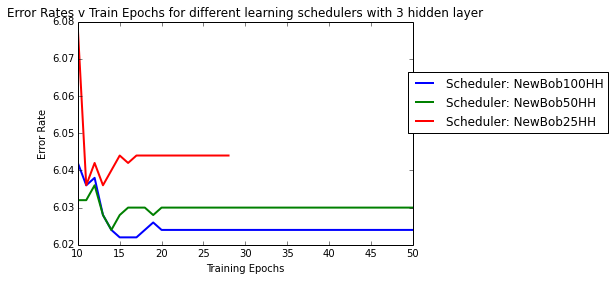

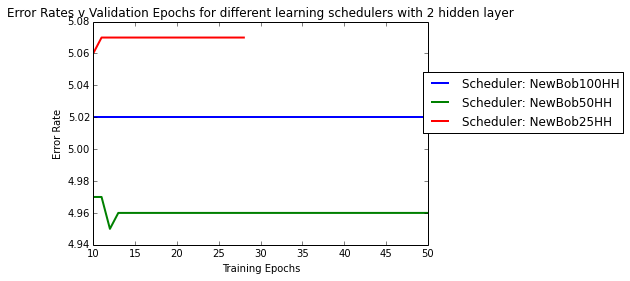

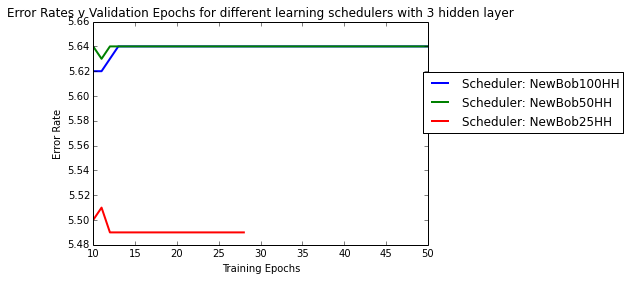

In [4]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100HH', 'NewBob50HH', 'NewBob25HH']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

This seemingly has no affect with the other hyper-parameters set as they are, suggesting that these rates need even more tuning together and not individually.

# TRY AND PUT IN NEW BOB WHICH ACTUALLY REASONABLE!

Below I've also experimented with the exponential learning rate, to show how this alters the error.

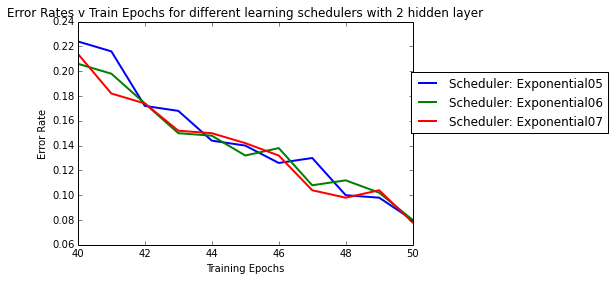

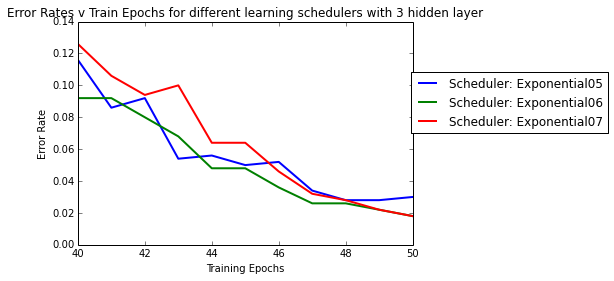

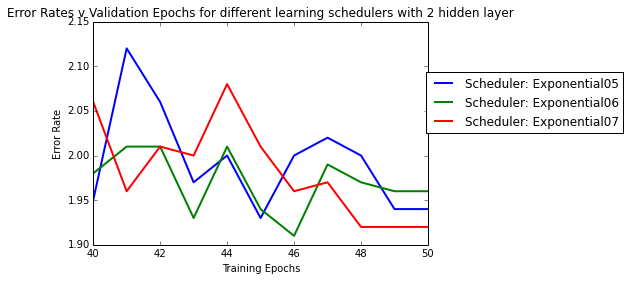

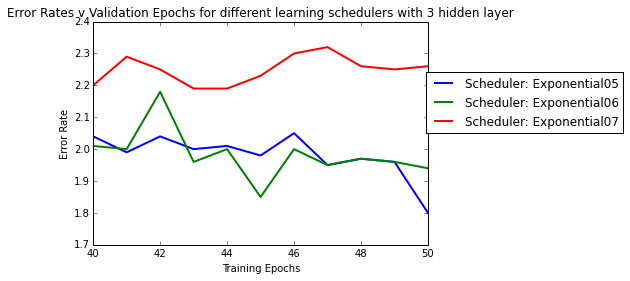

In [6]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['Exponential05', 'Exponential06', 'Exponential07']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[40:len(shelve_p[lists+str(i)][0])], train_error[40:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[40:len(shelve_p[lists+str(i)][0])], train_error[40:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

It is seemingly random with the continuous zero rate being equal to 0.5, therefore I also altered the zero-rate, as can be seen below, this time keeping the learning rate at 0.5 for different zero-rates:

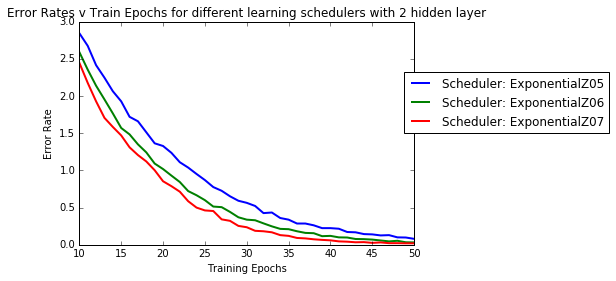

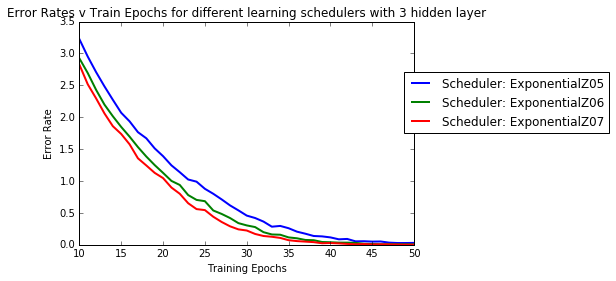

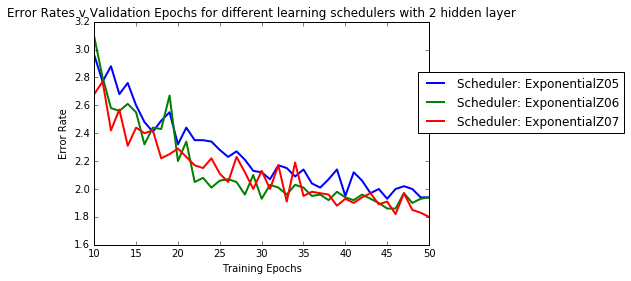

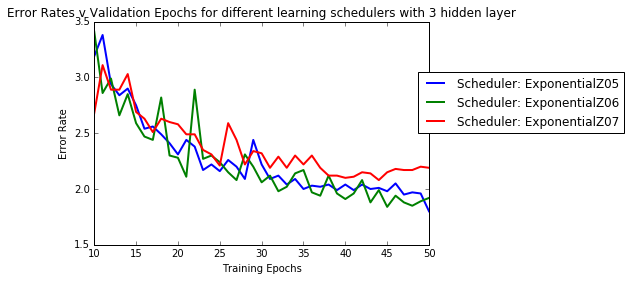

In [2]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperimentsExpZ")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['ExponentialZ05', 'ExponentialZ06', 'ExponentialZ07']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

# Conclusion
In conclusion, the fixed learning rate is the easiest to set, with minimal experiments needed to find the best rate for the networks.
However, newBob, exponential and the list schedulers need a lot more experimenting, but can provide more flexibility and better results with the right parameters. 

### Task 2 - Experiments with regularisers (5 marks)

Investigate the effect of different regularisation approaches (L1, L2, dropout).  Implement the annealing dropout scheduler (mentioned in lecture 5). Do some further investigations and experiments with model structures (and regularisers) of your choice. 

Firstly I performed a Grid search for the best L1, L2 and dropout rates.
Here are the L1 values, and test result upon the network when that rate is applied:

IndexError: too many indices

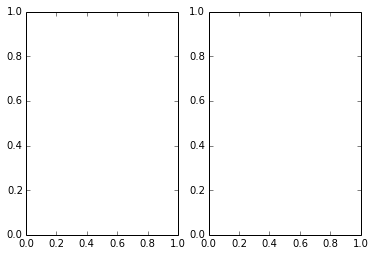

In [13]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("l1RegExperiments")
tracker = []

l1_weight = [0.005,0.001,0.0005,0.0001,0.00005]
for val in xrange(0,5):
    tracker.append([l1_weight[val], 100-(100*shelve_p[('l1F0'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
f , axarr = plt.subplots(1,2)
columns = ('L1 Rate', 'Error Rate in Testing')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
axarr[0,0].table(cellText=tracker,colLabels=columns, loc='best')
axarr[0,0].set_title('Result of L1 on the end result - 1 Hidden Layers')


tracker = []
for val in xrange(0,5):
    tracker.append([l1_weight[val], 100-(100*shelve_p[('l1F1'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('L1 Rate', 'Error Rate in Testing')
axarr[0,1].set_title('Result of L1 on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
axarr[0,1].table(cellText=tracker,colLabels=columns, loc='best')

plt.axis('off')
plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''

I then implemented annealed dropout, and used the best dropout rate as the base rate from which to experiment from.

#### Below Annealed Dropout is implemented:

In [ ]:
# %load -s DropoutAnnealed mlp/schedulers.py
class DropoutAnnealed(LearningRateList):
    '''

    Increase till 1, extends learning rate list to keep dropout values in order.
    Increases till 1, so that when other pieces of code do:
        p_inp_keep * layer will always return the layer.
    
    '''
    def __init__(self, p_inp_keep, p_hid_keep, constant_to_reduce):
        '''
        
            :type p_inp_keep: float
            :param p_inp_keep: Initial input layers' probability of dropout
            
            :type p_hid_keep: float
            :param p_hid_keep: Initial hidden layers' probability of dropout
            
            :type constant_to_reduce: float
            :param constant_to_reduce: Constant by which to increase at each epoch, until we reach 1
        
        '''
        
        #Assertion to ensure probabilities are good to use
        assert 0 < p_inp_keep <= 1 and 0 < p_hid_keep <= 1, (
            "Dropout 'keep' probabilites are suppose to be in (0, 1] range"
        )
        
        self.lr_temp = []
        
        '''
            To build up the rates, if the rates are set differently.
        '''
        if p_inp_keep > p_hid_keep:
            #Ensures we stop at one.
            while(p_hid_keep < 1):
                #Do in this order to stop probabilities larger than 1 being appended.
                self.lr_temp.append((p_inp_keep, p_hid_keep))
                '''
                    Want to check that the input prob is still under one, if we add to it
                    if it's not then we set to the upper bound of 1.
                '''
                if (p_inp_keep + constant_to_reduce) < 1:
                    p_inp_keep = p_inp_keep + constant_to_reduce
                else:
                    p_inp_keep = 1
                p_hid_keep = p_hid_keep + constant_to_reduce
        elif p_inp_keep < p_hid_keep:
            while(p_inp_keep < 1):
                #Do in this order to stop probabilities larger than 1 being appended.
                self.lr_temp.append((p_inp_keep, p_hid_keep))
                '''
                    Want to check that the hidden prob is still under one, if we add to it
                    if it's not then we set to the upper bound of 1.
                '''
                if (p_hid_keep + constant_to_reduce) < 1:
                    p_hid_keep = p_hid_keep + constant_to_reduce
                else:
                    p_hid_keep = 1
                p_inp_keep = p_inp_keep + constant_to_reduce
        else:
            #Build normally, as they are set together
            while(p_inp_keep < 1 and p_hid_keep < 1):
                #Do in this order to stop probabilities larger than 1 being appended.
                self.lr_temp.append((p_inp_keep, p_hid_keep))
                #Drop out annealed is supposed to increase by a constant amount.
                p_inp_keep = p_inp_keep + constant_to_reduce
                p_hid_keep = p_hid_keep + constant_to_reduce
        
        # Add the upperbounds anyway, as this is what the last one *should* be.
        self.lr_temp.append((1, 1))
        
        super(DropoutAnnealed, self).__init__(self.lr_temp, max_epochs=999)
        
      
    def get_rate(self):
        #Return the current dropout rate
        return self.lr_list[self.epoch]

    '''
        The reason we altered the optimisers
    '''
    def get_next_rate(self, current_accuracy=None):
        # Not ran out of rates yet so return
        if(self.epoch == len(self.lr_list)-1):
            return self.lr_list[self.epoch]
        # Increase epochs so the next rate is used.
        self.epoch += 1
        #Returns the last rate
        return self.lr_list[self.epoch]


And changes made to the optimiser to account for annealed dropout:

In [ ]:
# %load -r 118-125 mlp/optimisers.py
        
        '''
            Next epoch, next dropout rate if annealed, otherwise it just returns the dropout rate.
            Increments the epoch in the dropout scheduler so the next one is used.
        '''
        if self.dp_scheduler is not None:
            self.dp_scheduler.get_next_rate()
        

These changes were needed as otherwise there wasn't a active way to increase the epochs, therefore the next annealed dropout rate wouldn't be used. - look into if we need to check first

### Task 3 - Experiments with pretraining (15 marks)

Implement pretraining of multi-layer networks with autoencoders, denoising autoencoders, and using  layer-by-layer cross-entropy training.  

Implementation tip: You could add the corresponding methods to `optimiser`, namely, `pretrain()` and `pretrain_epoch()`, for autoencoders. Simiilarly, `pretrain_discriminative()` and `pretrain_epoch_discriminative()` for cross-entropy layer-by-layer pretraining. Of course, you can modify any other necessary pieces, but include all the modified fragments below.

In [ ]:
#Both auto-encoders and denoising? Deep autoencoders or just initial layer?
'''

Final Layer - 
Cross-entropy layer to layer - as expected

'''

Show implementations, show error rates in first 10 epochs, show result on testing rates and validation rates.

### Task 4 - Experiments with data augmentation (5 marks)

Using the standard MNIST training data, generate some augmented training examples (for example, using noise or rotation). Perform experiments on using this expanded training data.

In [ ]:
#Look at lab4 - Make for loops, to go through batch_size, as its currently just for individual images not batches.

#Show all augmentations, then how you picked the best to randomly use for all, and then how you used with dropout as at first it was over training.


### Task 5 - State of the art (5 marks)

Using any techniques you have learnt so far (combining any number of them), build and train the best model you can (no other constraints).

In [ ]:
#BUILD

# Part 2. Convolutional Neural Networks (55 marks)

In this part of the coursework, you are required to implement deep convolutional networks.  This includes code for forward prop, back prop, and weight updates for convolutional and max-pooling layers, and should support the stacking of convolutional + pooling layers.  You should implement all the parts relating to the convolutional layer in the mlp/conv.py module; if you decide to implement some routines in cython, keep them in mlp/conv.pyx). Attach both files in this notebook.

Implementation tips: Look at [lecture 7](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp07-cnn.pdf) and [lecture 8](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp08-cnn2.pdf), and the introductory tutorial, [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb)

### Task 6 -  Implement convolutional layer (20 marks)

Implement linear convolutional layer, and then extend to sigmoid and ReLU transfer functions (do it in a similar way to fully-connected layers). Include all relevant code.  It is recommended that you first implement in the naive way with nested loops (python and/or cython);  optionally you may then implement in a vectorised way in numpy.  Include logs for each way you implement the convolutional layer, as timings for different implementations are of interest.  Include all relevant code.

In [ ]:
import numpy
import logging
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
learning_rate = 0.5
max_epochs = 30
cost = CECost()
    
stats = []
for layer in xrange(1, 2):

    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()
    
    #define the model
    model = MLP(cost=cost)
    model.add_layer(ConvLinear(idim=784, odim=nhid, irange=0.2, rng=rng))
    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    # with fixed learning rate and max_epochs
    lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

    logger.info('Training started...')
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))
    
    stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

### Task 7 - Implement max-pooling layer (10 marks)

Implement a max-pooling layer. Non-overlapping pooling (which was assumed in the lecture presentation) is required. You may also implement a more generic solution with striding as well. Include all relevant code.

### Task 8 - Experiments with convolutional networks (25 marks)

Construct convolutional networks with a softmax output layer and a single fully connected hidden layer. Your first experiments should use one convolutional+pooling layer.  As a default use convolutional kernels of dimension 5x5 (stride 1) and pooling regions of 2x2 (stride 2, hence non-overlapping).

*  Implement and test a convolutional network with 1 feature map
*  Implement and test a convolutional network with 5 feature maps

Explore convolutional networks with two convolutional layers, by implementing, training, and evaluating a network with two convolutional+maxpooling layers with 5 feature maps in the first convolutional layer,  and 10 feature maps in the second convolutional layer.

Carry out further experiments to optimise the convolutional network architecture (you could explore kernel sizes and strides, number of feature maps, sizes and strides of pooling operator, etc. - it is up to you).

**This is the end of coursework 2.**

Please remember to save your notebook, and submit your notebook following the instructions at the top.  Please make sure that you have executed all the code cells when you submit the notebook.
